# Making predictions with BlazeFace

This notebook shows how to use the model for face detection.

In [1]:
import numpy as np
import torch
import cv2

In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.13.0
CUDA version: None
cuDNN version: None


In [3]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cpu')

Helper code for making plots:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.detach().cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i, 16])
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1, 
                                        edgecolor="lightskyblue", facecolor="none", 
                                        alpha=detections[i, 16])
                ax.add_patch(circle)
        
    plt.show()

## Load the front and back models

In [5]:
from blazeface import BlazeFace

front_net = BlazeFace().to(gpu)
front_net.load_weights("blazeface.pth")
front_net.load_anchors("anchors.npy")
back_net = BlazeFace(back_model=True).to(gpu)
back_net.load_weights("blazefaceback.pth")
back_net.load_anchors("anchorsback.npy")

# Optionally change the thresholds:
#front_net.min_score_thresh = 0.75
#front_net.min_suppression_threshold = 0.3
#back_net.min_score_thresh = 0.75
#back_net.min_suppression_threshold = 0.3

## Make a prediction

The input image should be 128x128 for the front model and 256x256 for the back model. BlazeFace will not automatically resize the image, you have to do this yourself!

In [6]:
img = cv2.imread("/Users/parul/NCS/PhantomBlaze/tile_blaze_70_single.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img, (256, 256))

In [7]:
back_net_img = back_net.predict_on_image(img)
back_net_img.shape

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


torch.Size([896, 17])

In [8]:
back_net_img.size()

torch.Size([896, 17])

In [9]:
back_net_img_1 = back_net_img[back_net_img[:,16]>0.5]

Found 152 faces


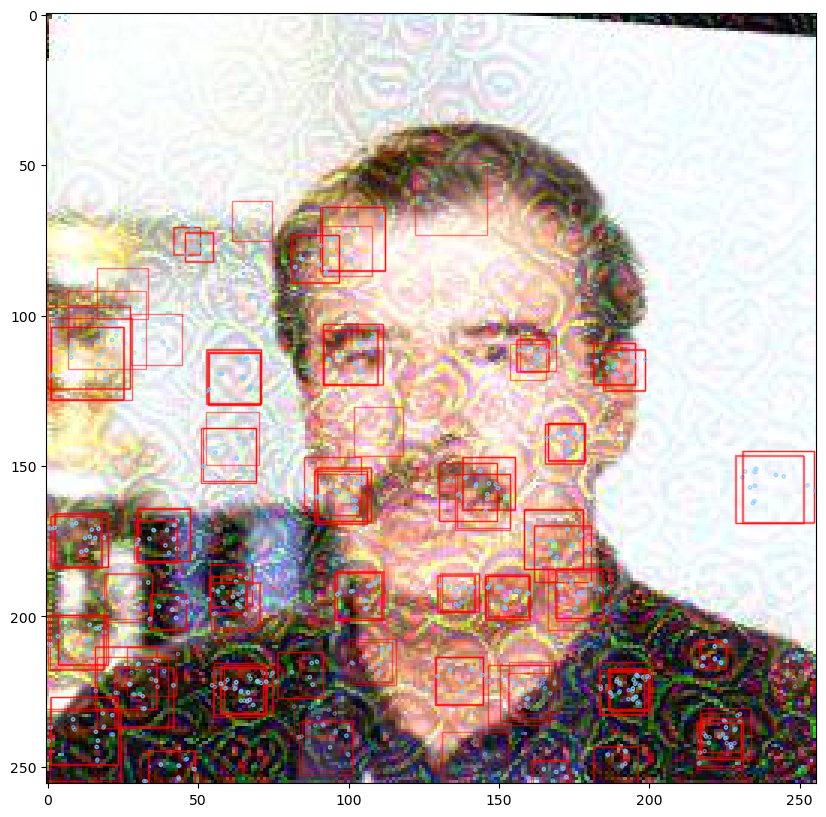

In [10]:
plot_detections(img, back_net_img_1)

In [11]:
img2 = cv2.resize(img, (256, 256))
back_detections = back_net.predict_on_image(img2)
back_detections.shape

torch.Size([896, 17])

In [12]:
back_detections

tensor([[-6.2386e-02, -5.1636e-02,  9.4601e-02,  ...,  7.9407e-02,
         -7.3414e-04,  2.3741e-02],
        [-8.5366e-02, -7.3708e-02,  1.2495e-01,  ...,  9.5638e-02,
          1.5198e-03,  3.9886e-02],
        [-6.2700e-02,  3.3646e-02,  8.4883e-02,  ...,  1.5402e-01,
         -1.2673e-02,  6.2677e-03],
        ...,
        [ 7.7376e-01,  7.3201e-01,  1.1380e+00,  ...,  1.0466e+00,
          8.8232e-01,  2.2104e-05],
        [ 8.0895e-01,  7.8630e-01,  1.1082e+00,  ...,  1.0459e+00,
          9.1398e-01,  3.9371e-05],
        [ 8.4410e-01,  8.3203e-01,  1.0436e+00,  ...,  1.0604e+00,
          9.1328e-01,  3.9015e-07]], grad_fn=<CatBackward0>)

In [ ]:
plot_detections(img2, back_detections)

## Make prediction on a batch of images

Load the images into a NumPy array of size `(batch, 128, 128, 3)` for front model or of size `(batch, 256, 256, 3)` for back model. Note: You could also use a PyTorch tensor here, in which case the shape must be `(batch, 3, 128, 128)` or `(batch, 3, 256, 256)`.

In [ ]:
filenames = [ "1face.png", "3faces.png", "4faces.png" ]

xfront = np.zeros((len(filenames), 128, 128, 3), dtype=np.uint8)
xback = np.zeros((len(filenames), 256, 256, 3), dtype=np.uint8)

for i, filename in enumerate(filenames):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    xfront[i] = img
    xback[i] = cv2.resize(img, (256, 256))

In [ ]:
front_detections = front_net.predict_on_batch(xfront)
[d.shape for d in front_detections]

In [ ]:
front_detections

In [ ]:
plot_detections(xfront[0], front_detections[0])

In [ ]:
plot_detections(xfront[1], front_detections[1])

In [ ]:
plot_detections(xfront[2], front_detections[2])

In [ ]:
back_detections = back_net.predict_on_batch(xback)
[d.shape for d in back_detections]

In [ ]:
back_detections

In [ ]:
plot_detections(xback[0], back_detections[0])

In [ ]:
plot_detections(xback[1], back_detections[1])

In [ ]:
plot_detections(xback[2], back_detections[2])